# "[SSUDA] 비지도 학습"
- author: Seong Yeon Kim 
- categories: [DACON, jupyter, EDA, Regression]

다양한 비지도 학습 방식을 이번기회에 공부하려고 합니다.

비지도 학습은 크게 이상치 탐지와 군집화 두 섹션으로 나눌 수 있는데요. 

이상치 탐지 중 IsolationForest를 중점적으로 공부하고, 군집화는 유명한 K-Means 이외에 거리기반 DBSCAN와 퍼지 군집을 살펴보겠습니다.

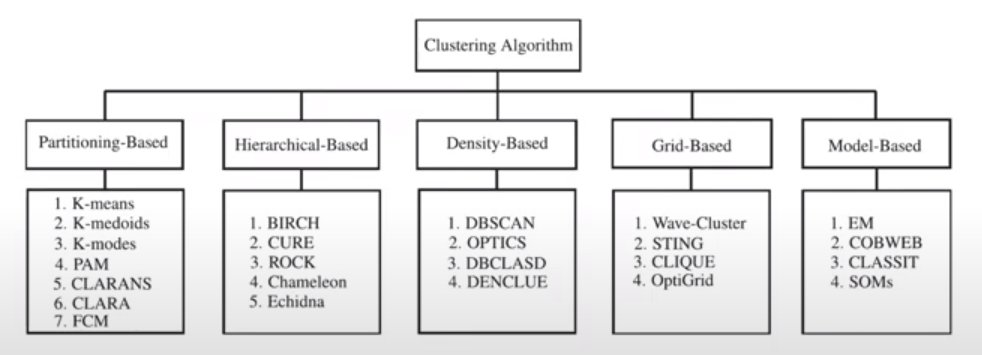

다양한 분야에 군집화 모델들 입니다.

# IsolationForest

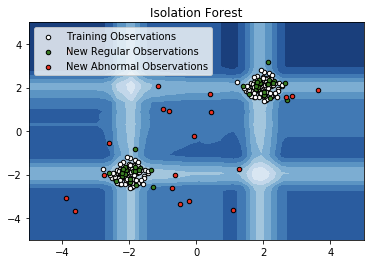

IsolationForest는 여러개의 변수가 있을 때 이상치를 찾아내는 기법입니다.

여러 개의 의사결정나무를 종합한 앙상블 기반의 이상탐지 기법인데요.

의사결정트리를 지속적으로 분기시키며 데이터 관측치가 어느정도 고립되었는지에 따라 이상치를 판별하는 방식입니다.

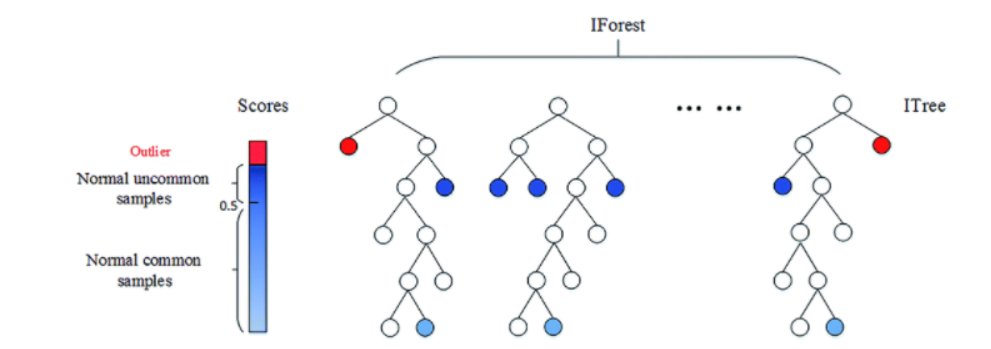

직관적으로 비정상 데이터라면 의사결정트리의 루트와 가까운 곳에서 고립이 될 것이라 생각합니다. 그림에서 빨간색 부분이죠.

알고리즘은 랜덤포레스트와 유사하게 매번 샘플링된 데이터를 이용하고 트리 분기에 사용할 변수들을 랜덤하게 선택합니다.

선택한 변수들의 최소/최대 값 사이에 정의된 유니폼 분포에서 샘플링하여 분기하게 됩니다.

이런식으로 트리를 여러번 분기하였을 때 데이터 별 루트 노드로부터의 평균 거리가 짧은 값을 이상치로 판별합니다.

IQR 이나 Z-score 대비 고차원에 데이터 형식일 때 성능도 괜찮고 컴퓨팅 효율도 좋습니다.

다만 이 기법을 적용하기 위해선 비정상 데이터가 다른 데이터와 다른 형태라는 가정이 필요합니다.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest

IsolationForest 모델은 사이킷런 내부에 존재해서 쉽게 사용할 수 있습니다.

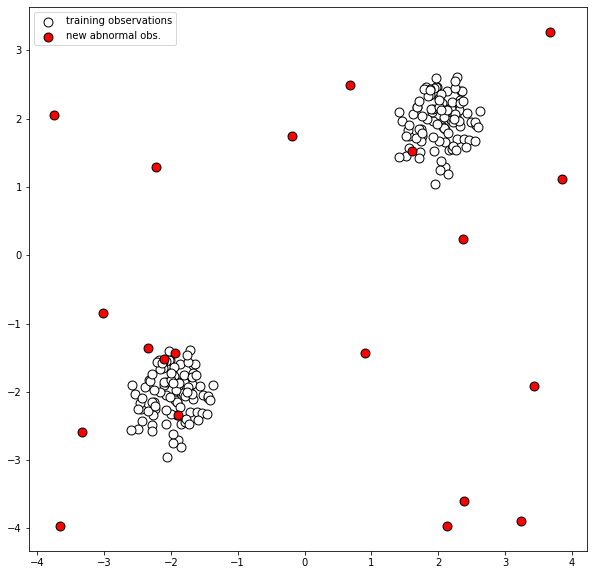

In [5]:
# 랜덤 스테이트 수치 설정하기
state_value = np.random.RandomState(20)

# 학습 데이터 생성하기
X = 0.3 * state_value.randn(100, 2)
X_train = np.r_[X + 2, X - 2] # 두 배열을 합쳐줌
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# 정규값과 비슷한 데이터 추가해주기
X = 0.3 * state_value.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# 정규적이지 않은 데이터 추가해주기(인위적인 이상값 구현을 위함)
X_outliers = state_value.uniform(low=-4, high=4, size=(20, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

# 생성한 데이터 시각화 하기
plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(X_train.x1, X_train.x2, c='white', s=20*4, edgecolor='k', label='training observations')
# p2 = plt.scatter(X_test.x1, X_test.x2, c='green', s=20*4, edgecolor='k', label='new regular obs.')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*4, edgecolor='k', label='new abnormal obs.')

plt.legend()

정상 데이터는 -2나 2 근방에 생성했고 비정상 데이터는 아에 랜덤으로 생성했습니다.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


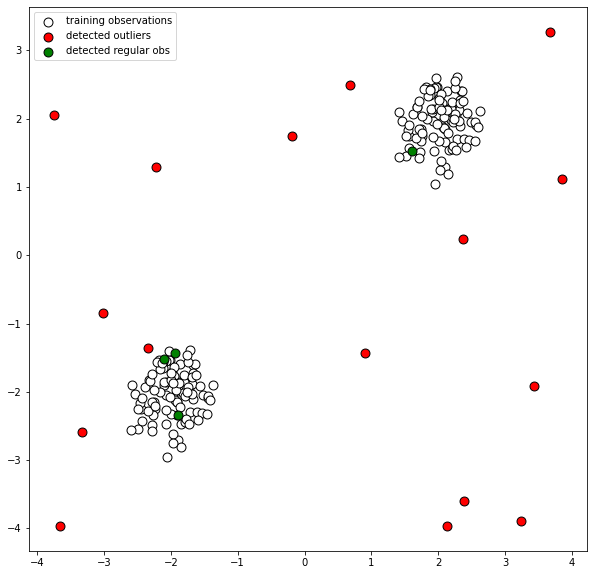

In [6]:
# IsolationForest 모델링하기
# max_samples : 정수일 경우 지정한 개수만큼, 0~1사이 실수이면 그 퍼센트만큼 데이터 샘플링.
# contamination : 전체 데이터 중 사용자가 생각하는 이상치 비율. 임계치로 활용됨.
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=42)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# 모델링이 잘 됬는지 시각화하기
X_outliers = X_outliers.assign(y = y_pred_outliers)
p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="detected regular obs")
plt.legend()

IsolationForest 모델 관련 핵심 파라미터 max_samples와 contamination을 설명했습니다.

모델의 출력값으로 정상 데이터는 1, 비정상 데이터는 -1을 출력합니다.

빨간색은 디텍팅한 비정상 데이터, 초록색은 디텍팅에 실패한 비정상 데이터입니다.

모델 가정과 들어 맞는 가상 데이터를 사용했지만 모델이 꽤 똘똘하게 돌아가는게 관찰됩니다.



# DBSCAN

DBSCAN은 Density-Based Spatial Clustering of Applications with Noise의 약자 입니다.

밀도 기반으로 클러스터링을 하며 노이즈를 적용한다는 뜻 입니다.

K-Means 모델은 이상치가 있어도 이상치 값을 이해할 수 없으며 군집의 중심 위치를 왜곡시키는 문제가 있습니다.

반면 DBSCAN은 특정 요소가 클러스터에 속하는 경우 해당 클러스터 내 다른 많은 요소와 가까운 위치에 있어야한다는 전제가 있습니다.

계산을 위해 직경(R), 최소 요소(M) 두 값을 사용합니다.

쉽게 값을 설명하면 직경(R)은 군집의 크기를 나타내며 최소 요소(M)는 군집을 이루기 위한 최소 데이터 개수를 나타냅니다.

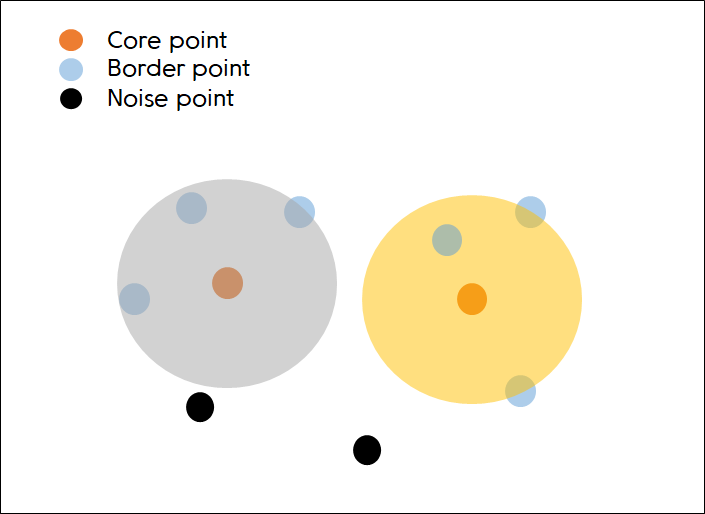

알고리즘 진행 과정을 간략하게 설명하면 우선 데이터 별로 R의 크기(원 넓이)를 체크해 주변 데이터가 몇 개 있는지 탐색합니다.

다음으로 R 크기 내 M개 이상의 데이터가 존재하면 해당 데이터를 군집의 중심값 취급합니다.

마지막으로 군집을 의미하는 원의 내부에 포함되지 못한 데이터는 이상값으로 취급되어 어느 군집에도 속하지 못한 값이 됩니다.

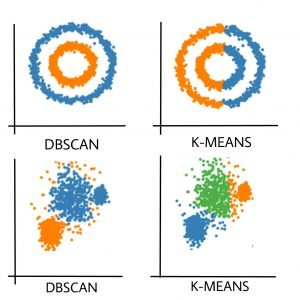

K-Means와 차이점을 나타 낸 그림입니다. 저런 형식의 데이터에 경우 K-Means 보다 DBSCAN이 훨씬 우수합니다.

또한 군집의 개수, K 값을 미리 지정할 필요가 없다는 것도 큰 장점입니다.

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import load_iris
import pandas as pd

iris_data = load_iris()
irisDF = pd.DataFrame(data=iris_data.data, columns=['sepal_length','sepal_width','petal_length','petal_width'])

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris_data.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris_data.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64


iris 데이터를 사용해 DBSCAN 모델을 적합시켰습니다. 

eps(R)과 min_samples(M)에 따라 다르겠지만 3 종류의 꽃을 두 종류로 구분하는 걸 보니 적절한 파라미터를 찾는 것 또한 골칫거리 입니다.

또 직관적으로 생각했을 때 차원이 높아진다면 거리의 측정이 애매해져서 이 모델을 적용하기 어려울 것 같습니다.

그리고 모든 데이터간 거리를 구해야 하기 때문에 데이터의 개수가 커진다면 시간복잡도가 상당히 높을 것으로 추측됩니다.

적절한 파라미터 2개를 찾아야하는데 시간복잡도 마저 높아진다면 골칫거리일 것 입니다.

이런 문제를 해결하고자 입력 파라미터를 제거한 DBCLASD 모델도 존재합니다.

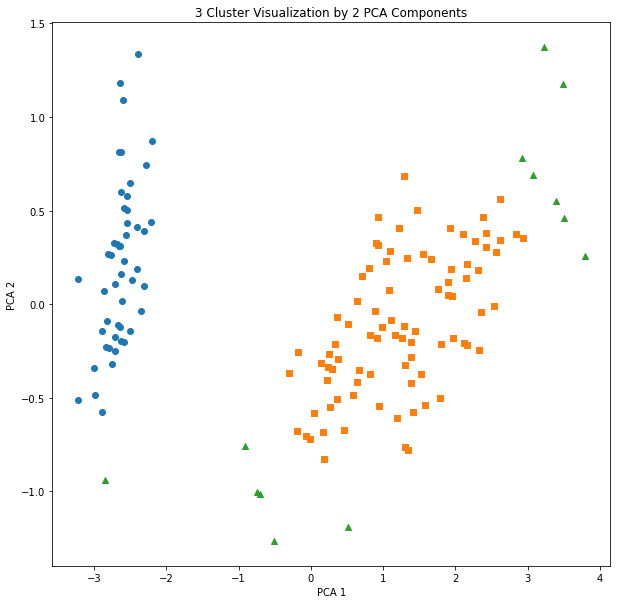

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(iris_data.data)

irisDF['pca_x'] = pca_transformed[:,0]
irisDF['pca_y'] = pca_transformed[:,1]
#print(irisDF)

maker0_ind = irisDF[irisDF['dbscan_cluster']==0].index
maker1_ind = irisDF[irisDF['dbscan_cluster']==1].index
maker2_ind = irisDF[irisDF['dbscan_cluster']==-1].index

plt.scatter(x=irisDF.loc[maker0_ind,'pca_x'], y=irisDF.loc[maker0_ind, 'pca_y'], marker='o')
plt.scatter(x=irisDF.loc[maker1_ind,'pca_x'], y=irisDF.loc[maker1_ind, 'pca_y'], marker='s')
plt.scatter(x=irisDF.loc[maker2_ind,'pca_x'], y=irisDF.loc[maker2_ind, 'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Cluster Visualization by 2 PCA Components')
plt.show()

iris 데이터를 2차원으로 차원 축소 한 뒤 시각화 하였습니다.

세모 모양은 모델이 이상치로 분류 한 데이터 입니다.

# 퍼지 군집

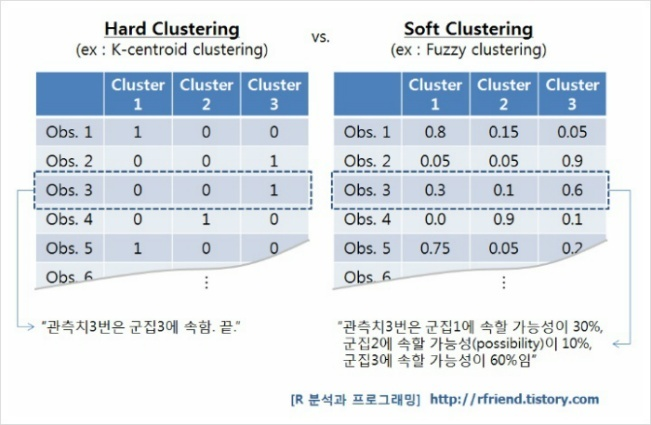

fuzzy는 '모호함, 애매함' 의 뜻을 가지는데 각 데이터가 한 개 이상의 군집에 속할 수 있도록 군집을 형성하는 것 입니다.

데이터의 분포를 보았을 때 특정 군집으로 분류하기 애매한 데이터가 많이 있다면 퍼지 군집을 선택하는 방법도 있습니다.

In [2]:
!pip install fuzzy-c-means

import numpy as np
from fcmeans import FCM
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typer
    Found existing installation: typer 0.4.2
    Uninstalling typer-0.4.2:
      Successfully uninstalled typer-0.4.2


퍼지 C-Means 모델을 사용하기 위해선 패키지 설치가 필요합니다.

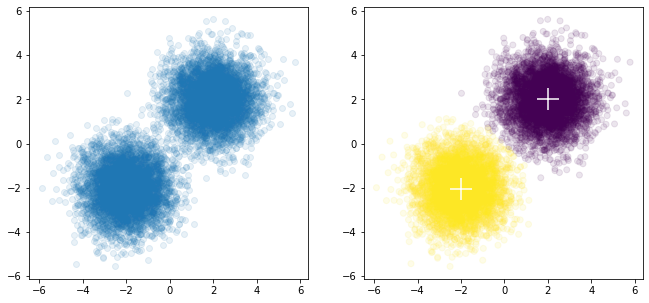

In [3]:
n_samples = 5000

X = np.concatenate((
    np.random.normal((-2, -2), size=(n_samples, 2)),
    np.random.normal((2, 2), size=(n_samples, 2))
))

# 클러스터 개수를 지정해야 합니다.
fcm = FCM(n_clusters=2)
fcm.fit(X)


# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)

# plot result
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(X[:,0], X[:,1], alpha=.1)
axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='w')
plt.show()

시각화 부분만 확인하면 군집의 수를 정해야하는 등 K-means와 유사합니다.

In [6]:
fcm.u

array([[0.018585  , 0.981415  ],
       [0.12806578, 0.87193422],
       [0.02850495, 0.97149505],
       ...,
       [0.94492172, 0.05507828],
       [0.99808667, 0.00191333],
       [0.97513129, 0.02486871]])

하지만 각 데이터 마다 어느 군집에 들어가 있는지 확률을 제공합니다.

데이터마다 어느 군집에 속할 지 애매하거나 실제로 여러 군집에 부분적으로 속해있을 수 있는 경우 사용하기 좋습니다.

# 참고자료

Isolation Forest

https://hongl.tistory.com/150

https://partrita.github.io/posts/isolation-forest/

DBSCAN

https://needjarvis.tistory.com/720

https://nicola-ml.tistory.com/10

퍼지군집

https://syj9700.tistory.com/41

https://towardsdatascience.com/fuzzy-c-means-clustering-is-it-better-than-k-means-clustering-448a0aba1ee7